# XGBoost Modeling

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_validate
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score, make_scorer

import warnings
warnings.filterwarnings("ignore")

C:\Users\zasz\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\zasz\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


# 1.1 Load Data

In [2]:
# non-engineered data
df = pd.read_csv("train.csv")

# engineered data
df_eng = pd.read_csv("train_engineered.csv")

df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,80.111572,33.942432,85.101608,46.169139,125.593624,100.292107,Spondylolisthesis
1,63.404481,14.115327,48.136806,49.289153,111.916008,31.784495,Spondylolisthesis
2,52.419385,19.011561,35.872660,33.407825,116.559771,1.694705,Hernia
3,91.468741,24.508177,84.620272,66.960564,117.307897,52.623047,Spondylolisthesis
4,44.362490,8.945435,46.902096,35.417055,129.220682,4.994195,Normal


In [3]:
df_eng.head()

,lumbar_lordosis_angle,pelvic_radius,class__Hernia,class__Normal,class__Spondylolisthesis
0,85.101608,125.593624,0,0,1
1,48.136806,111.916007,0,0,1
2,35.872660,116.559771,1,0,0
3,84.620272,117.307897,0,0,1
4,46.902096,129.220682,0,1,0


# 1.2 One Hot Encode Target Variable

In [4]:
# ohe non-engineered data
dummies = pd.get_dummies(df["class"], prefix="class_")
df.drop("class", axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)

df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class__Hernia,class__Normal,class__Spondylolisthesis
0,80.111572,33.942432,85.101608,46.169139,125.593624,100.292107,0,0,1
1,63.404481,14.115327,48.136806,49.289153,111.916008,31.784495,0,0,1
2,52.419385,19.011561,35.872660,33.407825,116.559771,1.694705,1,0,0
3,91.468741,24.508177,84.620272,66.960564,117.307897,52.623047,0,0,1
4,44.362490,8.945435,46.902096,35.417055,129.220682,4.994195,0,1,0


# 2.1 Preprocessing

Here I will seperate the independent and dependent variables. I will also scale the independent variables.

In [5]:
# seperate independent and dependent variables

targets = [col for col in df if col.startswith("class")]

# non-engineered data
X = df.drop(targets, axis=1)
y_hernia = df["class__Hernia"]
y_spond = df["class__Spondylolisthesis"]

# engineered data
Xe = df_eng.drop(targets, axis=1)
ye_hernia = df_eng["class__Hernia"]
ye_spond = df_eng["class__Spondylolisthesis"]

X.shape, y_hernia.shape, y_spond.shape, Xe.shape, ye_hernia.shape, ye_spond.shape

((279, 6), (279,), (279,), (279, 2), (279,), (279,))

In [6]:
# scale data
sc = StandardScaler()

# non-engineered data
X = sc.fit_transform(X)

# engineered data
Xe = sc.fit_transform(Xe)

# 3.1 Baseline Models

Here I will look at the baseline performance of the default LogisticRegression model on the data sets. I will use cross validation.

In [7]:
# instantiate the default logistic regression model
clf = XGBClassifier()

In [8]:
# create a function to print desired scores
scorers = [make_scorer(g) for g in [recall_score, precision_score, accuracy_score]]

def find_scores(classifier, X, y, scorers):
    for scorer, score_type in zip(scorers, ["recall", "precision", "accuracy"]):
        print(f"\n\n{score_type}")
        results = cross_validate(clf, X, y, scoring=scorer, cv=4)["test_score"]
        print(results)
        print("avg:", sum(results)/4)
        print("var:", np.array(results).var())

# run function on non-engineered data pertaining to hernias
find_scores(clf, X, y_hernia, scorers)



recall
[0.5        0.64285714 0.61538462 0.61538462]
avg: 0.5934065934065934
var: 0.0030340538582296845


precision
[0.7        0.9        0.66666667 0.61538462]
avg: 0.7205128205128205
var: 0.011646942800788955


accuracy
[0.85915493 0.91428571 0.86956522 0.85507246]
avg: 0.8745195812556499
var: 0.0005550384893077536


In [9]:
# find scores for non-engineered data pertaining to Spondylolisthesis
find_scores(clf, X, y_spond, scorers)



recall
[0.97058824 0.97058824 1.         0.96969697]
avg: 0.9777183600713013
var: 0.00016562288503150404


precision
[0.89189189 1.         0.97142857 0.94117647]
avg: 0.9511242334771746
var: 0.0016021337422521108


accuracy
[0.92857143 0.98571429 0.98571429 0.95652174]
avg: 0.9641304347826087
var: 0.000563515103583967


In [10]:
# find scores for engineered data pertaining to hernia
find_scores(clf, Xe, ye_hernia, scorers)



recall
[0.5        0.28571429 0.38461538 0.23076923]
avg: 0.3502747252747253
var: 0.010511638087187537


precision
[0.7        0.36363636 0.55555556 0.33333333]
avg: 0.4881313131313131
var: 0.02222394398530762


accuracy
[0.85915493 0.75714286 0.82608696 0.76811594]
avg: 0.8026251713177616
var: 0.0017513991856670243


In [11]:
# find scores for engineered data pertaining to Spondylolisthesis
find_scores(clf, Xe, ye_spond, scorers)



recall
[0.67647059 0.64705882 0.82352941 0.84848485]
avg: 0.7488859180035652
var: 0.007776083817095138


precision
[0.82142857 0.75862069 0.8        0.84848485]
avg: 0.807133527392148
var: 0.0010796656696158884


accuracy
[0.77142857 0.72857143 0.81428571 0.85507246]
avg: 0.7923395445134576
var: 0.0022301737330092733


Overall the non-engineered data seemed to work the best so far.

# 4.1 Hyper paramerer tuning

Now I will tune the hyper parameters for the models. From now on I am only concerned with the non-engineered data.

In [12]:
# explore parameter tuning for finding hernias
params = {"max_depth":[2,3,4,5,None],
         "n_estimators":[50, 100, 200]}
gscv = GridSearchCV(clf, params, cv=4)
gscv.fit(X, y_hernia)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsampl

In [13]:
print(gscv.best_estimator_.get_params()["max_depth"])
print(gscv.best_estimator_.get_params()["n_estimators"])

2
50


In [14]:
# baseline scores
find_scores(clf, X, y_hernia, scorers)



recall
[0.5        0.64285714 0.61538462 0.61538462]
avg: 0.5934065934065934
var: 0.0030340538582296845


precision
[0.7        0.9        0.66666667 0.61538462]
avg: 0.7205128205128205
var: 0.011646942800788955


accuracy
[0.85915493 0.91428571 0.86956522 0.85507246]
avg: 0.8745195812556499
var: 0.0005550384893077536


In [15]:
# after tuning
find_scores(gscv.best_estimator_, X, y_hernia, scorers)



recall
[0.5        0.64285714 0.61538462 0.61538462]
avg: 0.5934065934065934
var: 0.0030340538582296845


precision
[0.7        0.9        0.66666667 0.61538462]
avg: 0.7205128205128205
var: 0.011646942800788955


accuracy
[0.85915493 0.91428571 0.86956522 0.85507246]
avg: 0.8745195812556499
var: 0.0005550384893077536


In [16]:
# explore parameter tuning for finding hernias
gscv2 = GridSearchCV(clf, params, cv=4)
gscv2.fit(X, y_spond)

GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsampl

In [17]:
print(gscv2.best_estimator_.get_params()["max_depth"])
print(gscv2.best_estimator_.get_params()["n_estimators"])

2
100


In [18]:
# baseline scores
find_scores(clf, X, y_spond, scorers)



recall
[0.97058824 0.97058824 1.         0.96969697]
avg: 0.9777183600713013
var: 0.00016562288503150404


precision
[0.89189189 1.         0.97142857 0.94117647]
avg: 0.9511242334771746
var: 0.0016021337422521108


accuracy
[0.92857143 0.98571429 0.98571429 0.95652174]
avg: 0.9641304347826087
var: 0.000563515103583967


In [19]:
# after tuning
find_scores(gscv2.best_estimator_, X, y_spond, scorers)



recall
[0.97058824 0.97058824 1.         0.96969697]
avg: 0.9777183600713013
var: 0.00016562288503150404


precision
[0.89189189 1.         0.97142857 0.94117647]
avg: 0.9511242334771746
var: 0.0016021337422521108


accuracy
[0.92857143 0.98571429 0.98571429 0.95652174]
avg: 0.9641304347826087
var: 0.000563515103583967


# 5.1 Feature Importance

Here I will take a look at the coefficients of each feature.

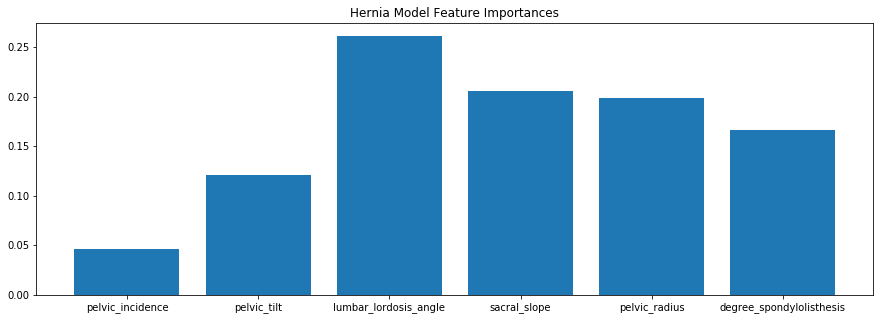

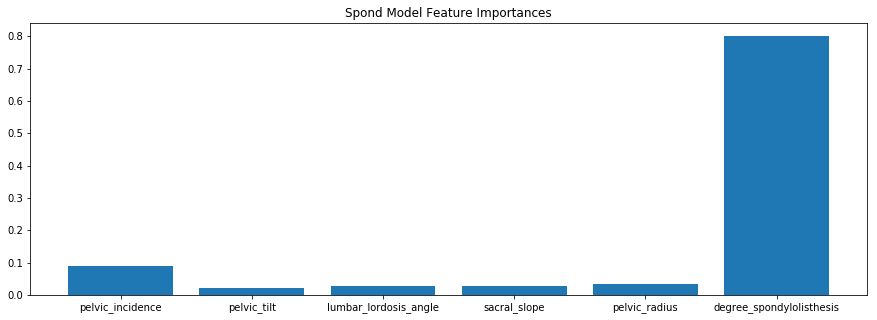

In [20]:
# save models
model_hernia = gscv.best_estimator_
model_spond = gscv2.best_estimator_

# save coeficients
cols = df.drop(targets, axis=1).columns
imp_hernia = model_hernia.feature_importances_
imp_spond = model_spond.feature_importances_


# plotting
plt.figure(figsize=(15, 5))
plt.bar(cols, imp_hernia)
plt.title("Hernia Model Feature Importances")
plt.show()

print("\n\n\n")

plt.figure(figsize=(15, 5))
plt.bar(cols, imp_spond)
plt.title("Spond Model Feature Importances")
plt.show()